In [17]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [18]:
def plot_first_three_channels_spectrum(signal_df, subject, data_type, sampling_rate, max_frequency=50):
    """
    Plots the spectrum (FFT) of the first three channels (data from electrodes) of the EEG signal dataframe.
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharey=True, tight_layout=True)

    for i in range(3):
        # Perform FFT
        signal = signal_df.iloc[:, i]
        n = len(signal)
        freq = np.fft.fftfreq(n, d=1/sampling_rate)
        spectrum = np.fft.fft(signal)
        
        # Filter the frequencies and spectrum to the max_frequency
        indices = np.where(freq >= 0)  # Only use non-negative frequencies
        freq = freq[indices]
        spectrum = np.abs(spectrum[indices])
        
        max_index = np.where(freq <= max_frequency)[0][-1]
        
        # Plot the magnitude spectrum
        axes[i].plot(freq[:max_index], spectrum[:max_index])
        axes[i].set_title(f"Channel {i+1} Spectrum")
        axes[i].set_xlabel('Frequency (Hz)')
        if i == 0:
            axes[i].set_ylabel('Magnitude')

    plt.suptitle(f"Subject {subject} - {data_type} EEG Signal Spectra (up to {max_frequency} Hz)", fontsize=16)

    plt.show()

In [19]:
def filter_signal(signal_df):
    """
    Filters the EEG signal using a Common Average Reference Filter (CAR)
    """

    # Calculate the average across all channels (columns) for each time point (row)
    average_signal = signal_df.mean(axis=1)
    
    # Subtract the average from each channel using broadcasting
    processed_signal_df = signal_df.sub(average_signal, axis=0)

    return processed_signal_df

In [20]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    """
    Design a bandpass filter using the Butterworth filter method
    """
    
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply a bandpass filter to the data
    """
    
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [21]:
fs = 512 # Sampling frequency in Hz
lowcut_mu = 8
highcut_mu = 13
lowcut_beta = 13
highcut_beta = 30
num_subjects = 3
num_electrodes = 15

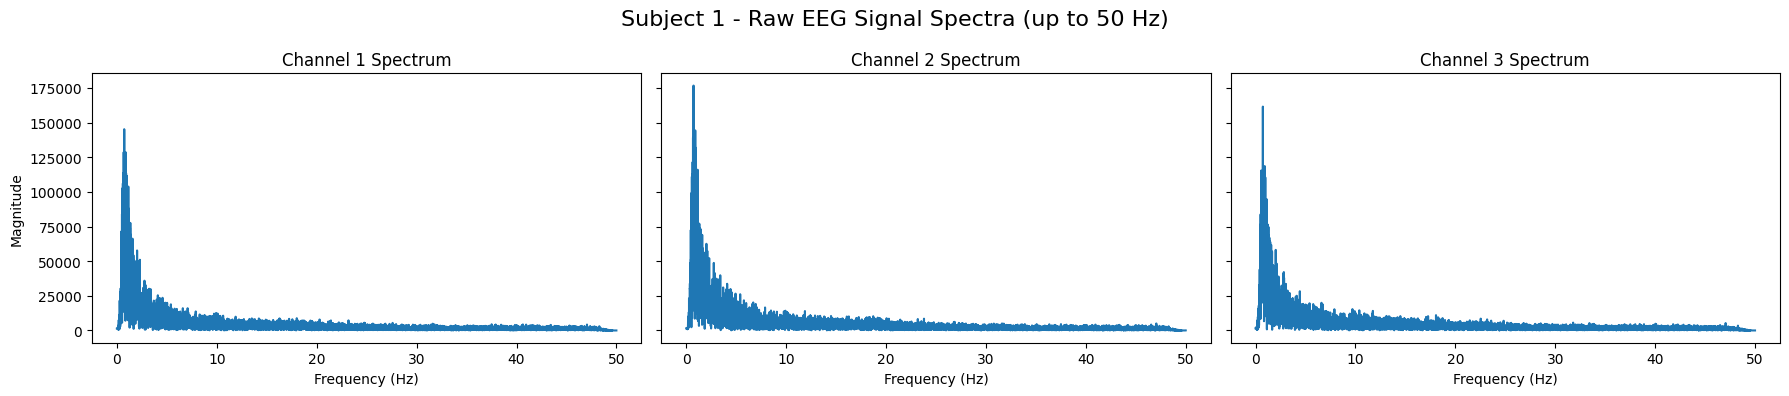

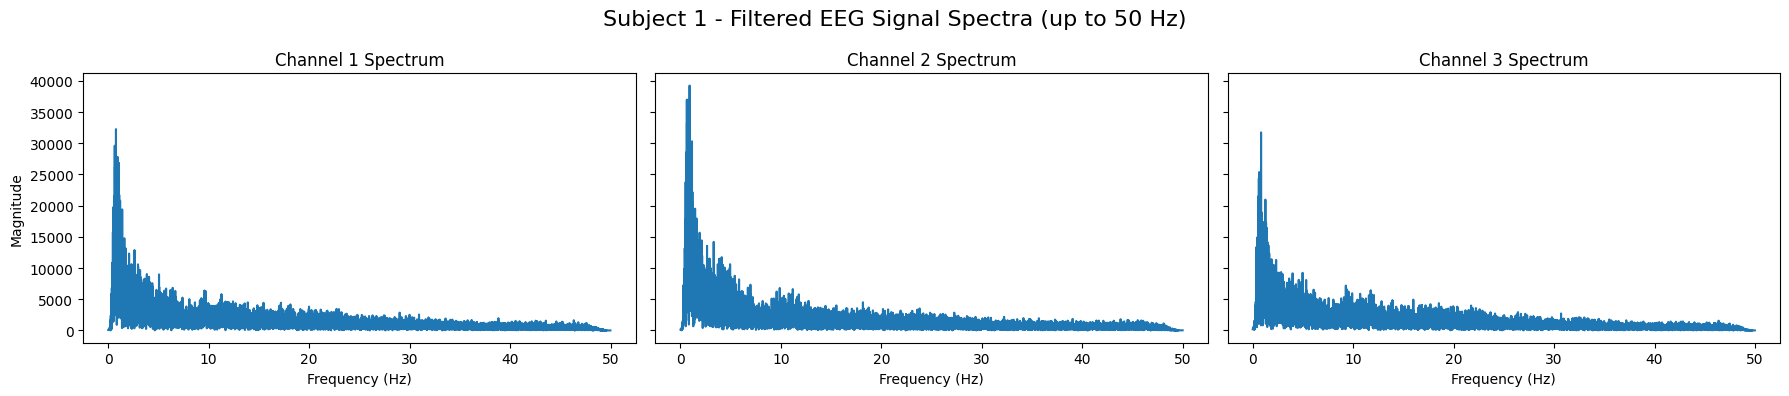

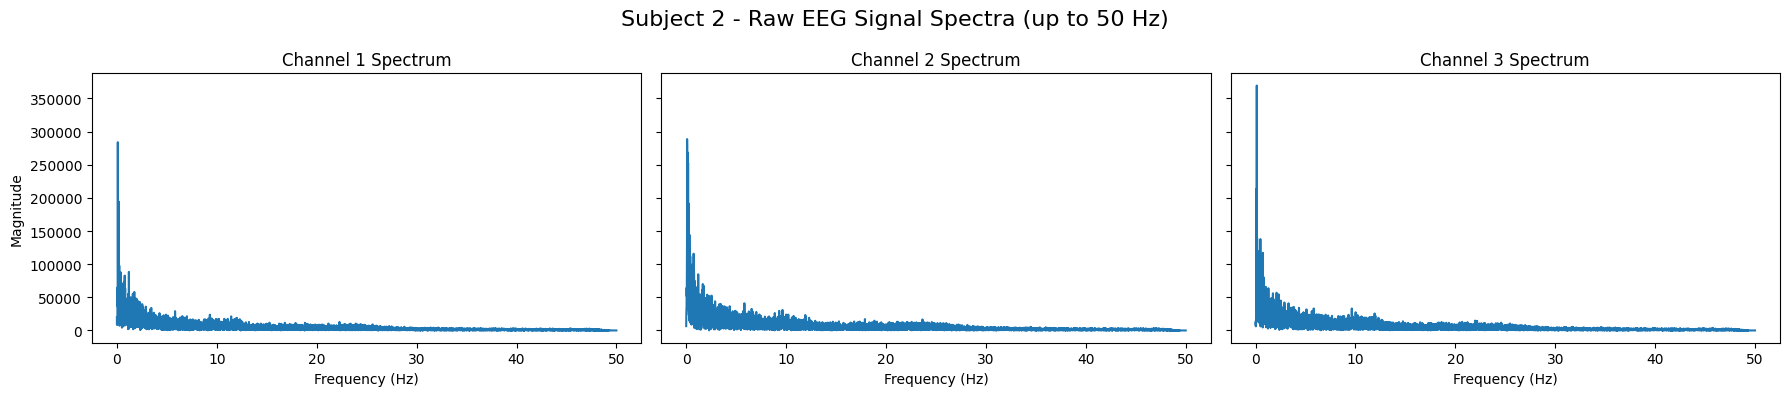

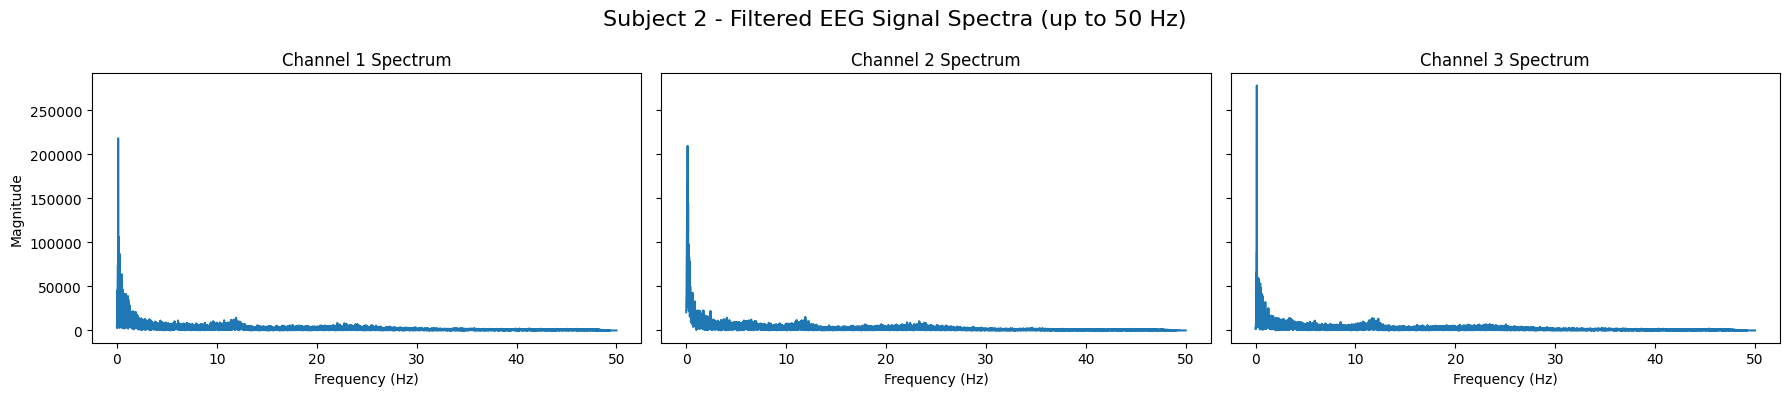

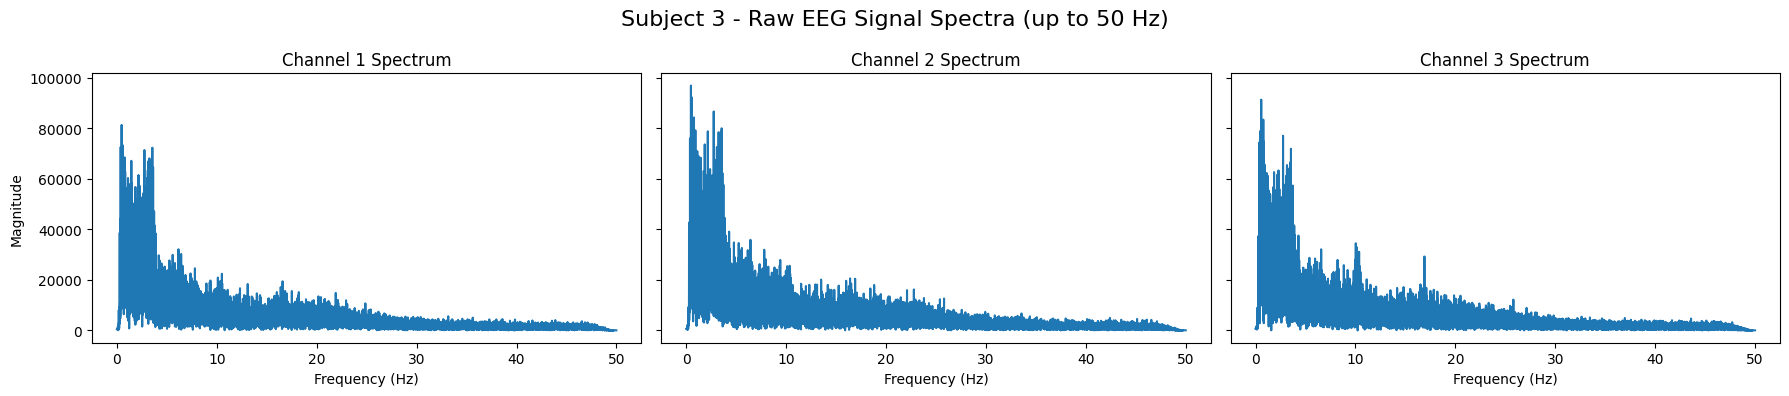

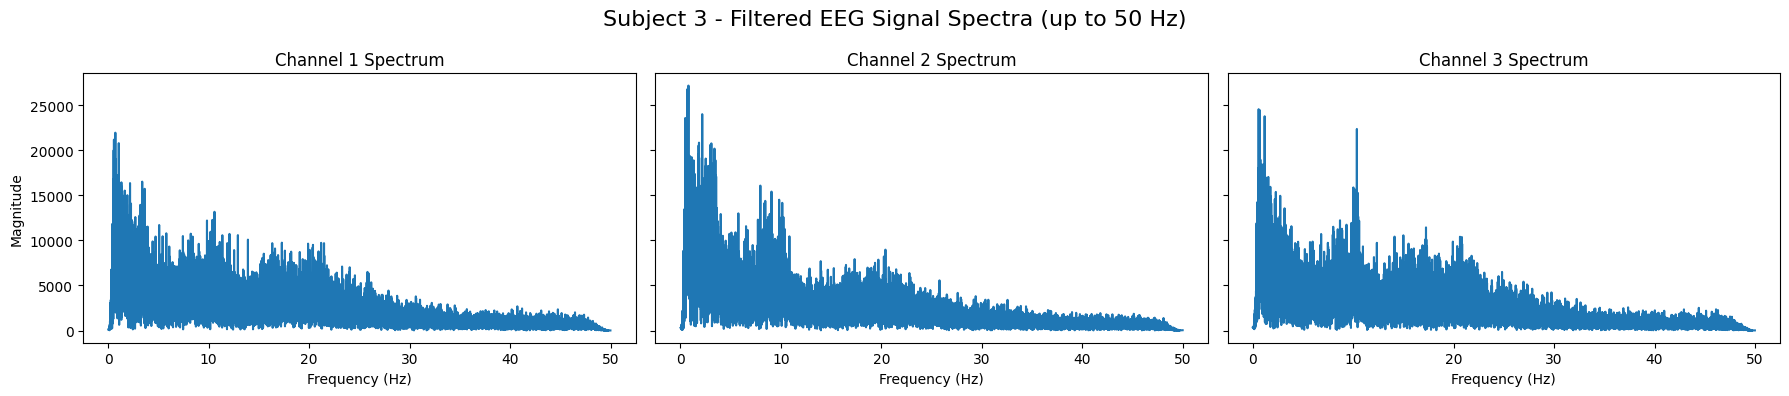

In [22]:
filtered_subjects = []

for subject in range(1, num_subjects+1):
    signals = pd.read_csv(f"../data/raw/subject_{subject}/Subject{subject}_Signals.csv")

    plot_first_three_channels_spectrum(signals, subject=subject, data_type="Raw", sampling_rate=fs)
    
    filtered_signals = filter_signal(signals)
    filtered_subjects.append(filtered_signals)
    filtered_signals.to_csv(f"../data/processed/subject_{subject}/Subject{subject}_Signals_CAR.csv", index=False)

    plot_first_three_channels_spectrum(filtered_signals, subject=subject, data_type="Filtered", sampling_rate=fs)

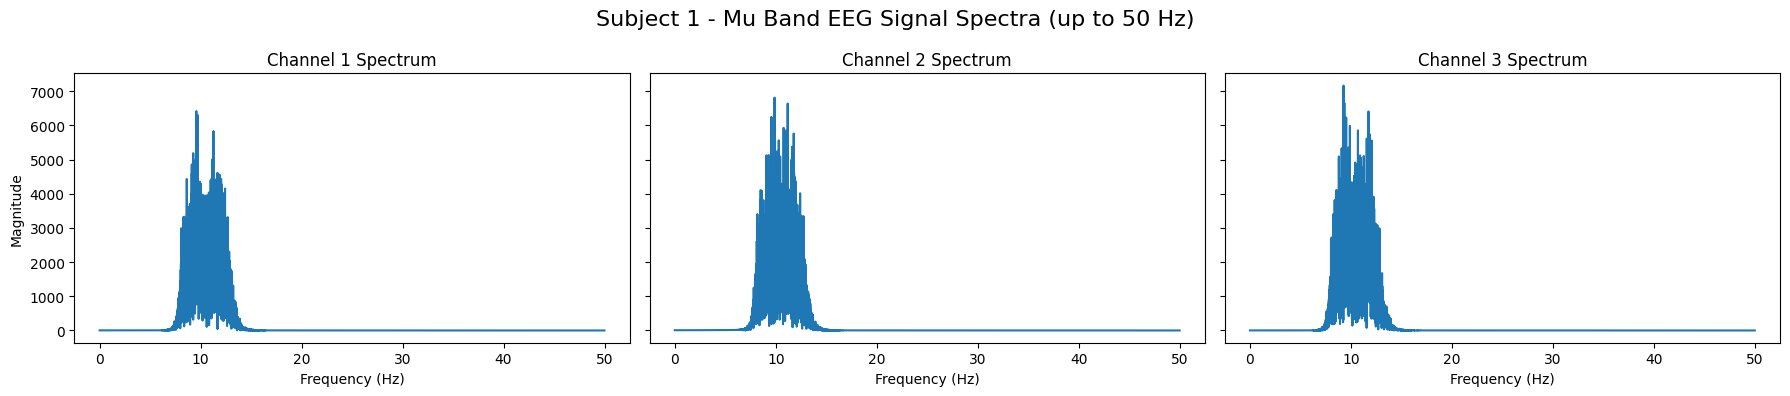

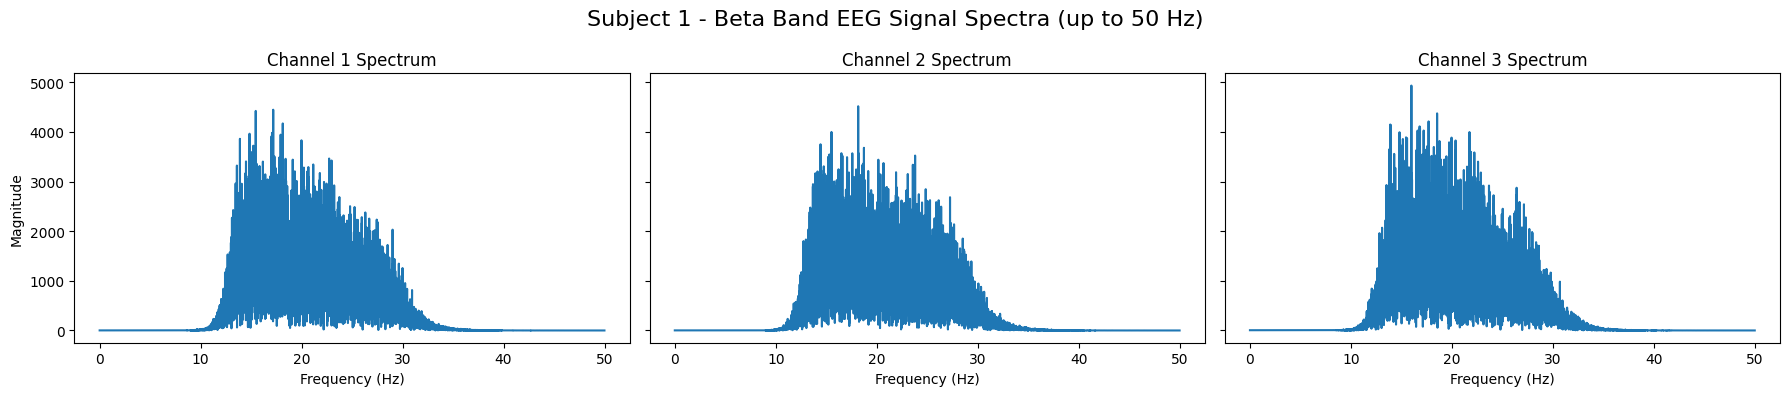

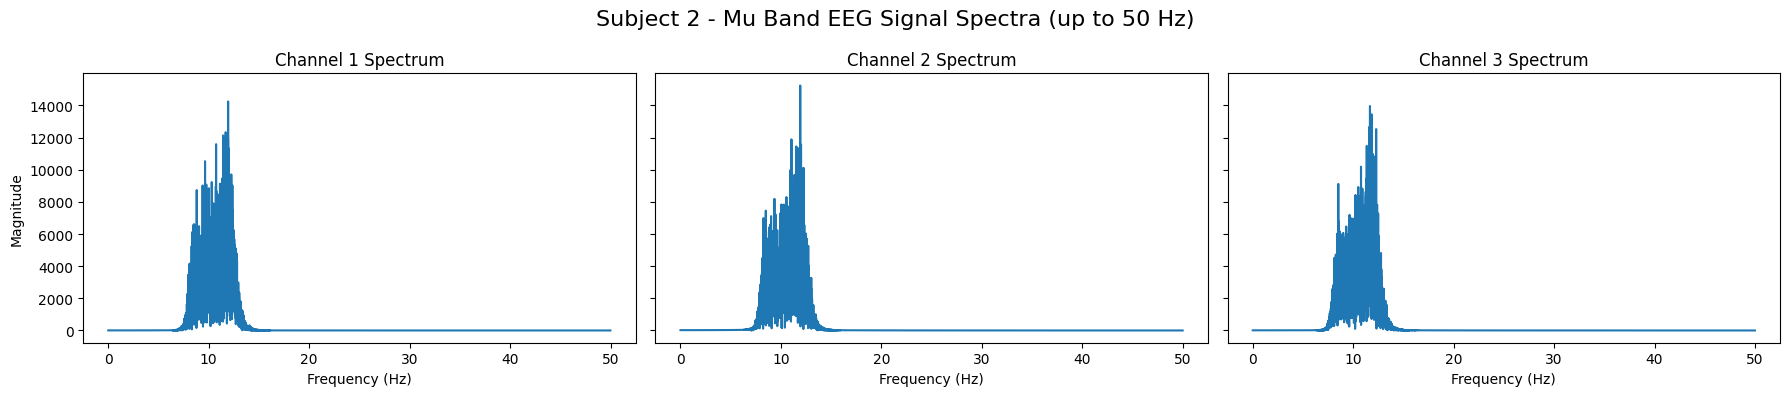

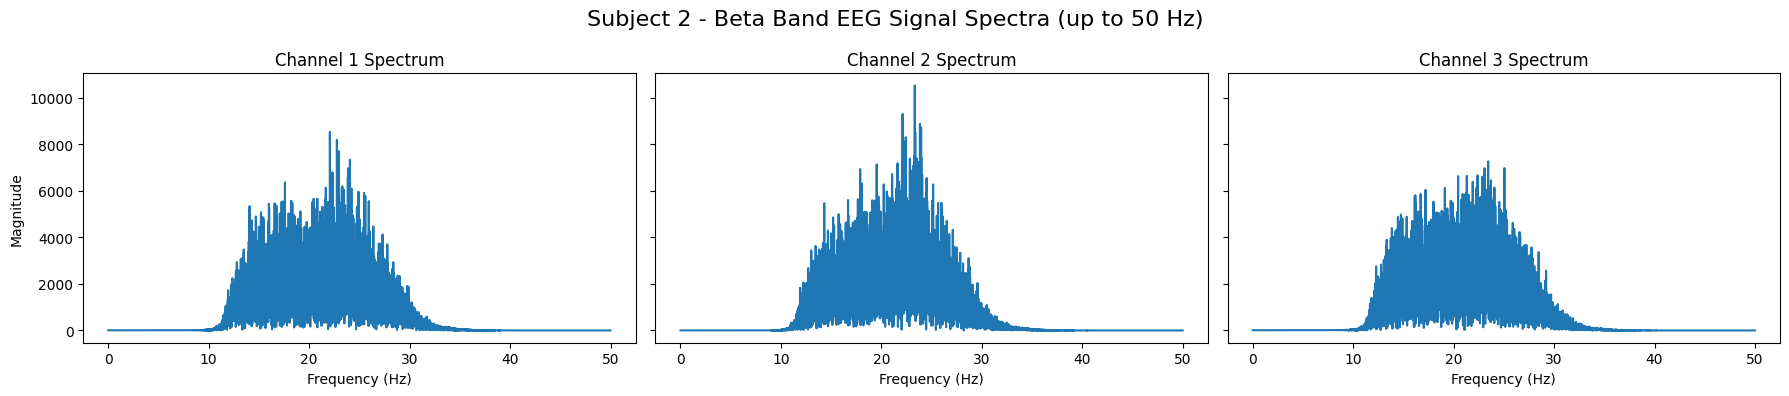

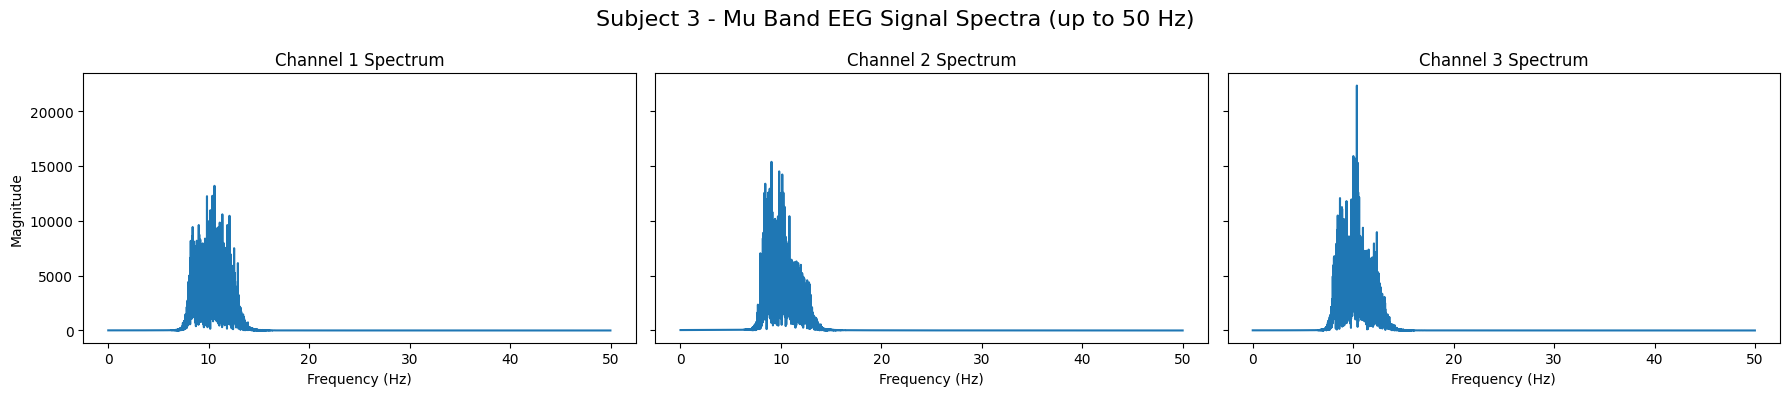

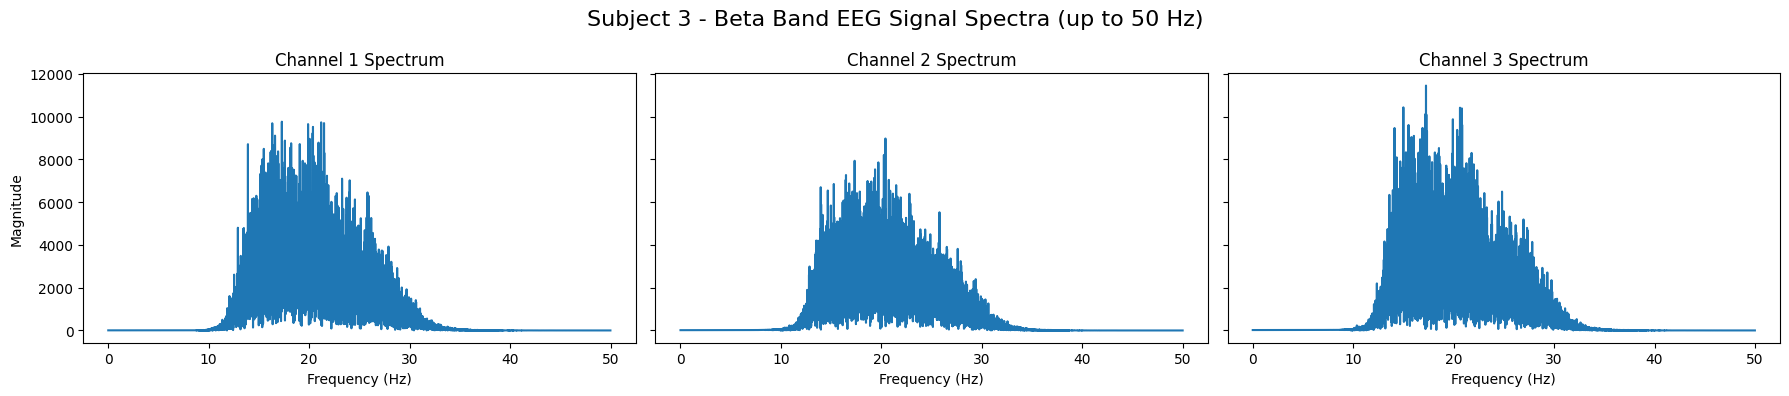

In [23]:
subjects_mu_band_data = []
subjects_beta_band_data = []

for subject, filtered_signals in enumerate(filtered_subjects, 1):
    mu_band_data = filtered_signals.apply(bandpass_filter, args=(lowcut_mu, highcut_mu, fs))
    subjects_mu_band_data.append(mu_band_data)
    mu_band_data.to_csv(f"../data/processed/subject_{subject}/Subject{subject}_Mu_Band.csv", index=False)

    plot_first_three_channels_spectrum(mu_band_data, subject=subject, data_type="Mu Band", sampling_rate=fs)

    beta_band_data = filtered_signals.apply(bandpass_filter, args=(lowcut_beta, highcut_beta, fs))
    subjects_beta_band_data.append(beta_band_data)
    beta_band_data.to_csv(f"../data/processed/subject_{subject}/Subject{subject}_Beta_Band.csv", index=False)

    plot_first_three_channels_spectrum(beta_band_data, subject=subject, data_type="Beta Band", sampling_rate=fs)
    

# Computing Relative Change for all trials for each label for all subjects

In [24]:
subjects_trials_class1 = [] # trials for moving right hand
subjects_trials_class2 = [] # trials for moving feet
subjects_labels = []

for subject in range(1, num_subjects+1):
    trials = []
    trials = pd.read_csv(f"../data/raw/subject_{subject}/Subject{subject}_Trial.csv", header=None)
    labels = pd.read_csv(f"../data/raw/subject_{subject}/Subject{subject}_Labels.csv", header=None)

    class1 = []
    class2 = []
    for i in range(trials.shape[1]):
        if labels.iloc[0, i] == 1:
            class1.append(trials.iloc[:, i])
        else:
            class2.append(trials.iloc[:, i])
    
    subjects_trials_class1.append(class1)
    subjects_trials_class2.append(class2)

    subjects_labels.append(labels)

In [25]:
def compute_power(signal):
    """ 
    compute the average power of the signal
    """
    power_channel = np.sum(signal**2, axis=0)
    return power_channel / len(signal)

In [26]:
def computeRelativeChange(signal, trials):
    """
    Compute the relative change in power of the signal for all trials
    """
    relative_changes = []
    for trial in trials:
        start_experiment = int(trial[0])
        end_experiment = start_experiment + 5*fs
        start_preonset = start_experiment - 5 * fs


        power_preonset = compute_power(signal.iloc[start_preonset:start_experiment])
        power_experiment = compute_power(signal.iloc[start_experiment:end_experiment])

        relative_change = (power_experiment - power_preonset) / power_preonset
        relative_changes.append(relative_change)
    return relative_changes

In [27]:
subjects_relative_change = {
    'mu_band_class1': [],
    'mu_band_class2': [],
    'beta_band_class1': [],
    'beta_band_class2': [],
}

In [28]:
for subject in range(num_subjects):
    for band in ['mu', 'beta']:
        band_data = subjects_mu_band_data[subject] if band == 'mu' else subjects_beta_band_data[subject]
        for trial_class in [1,2]:
            trials = subjects_trials_class1[subject] if trial_class == 1 else subjects_trials_class2[subject]
            relative_change = computeRelativeChange(band_data, trials)
            subjects_relative_change[f"{band}_band_class{trial_class}"].append(relative_change)  

In [29]:
for subject in range(num_subjects):
    for band in ['mu', 'beta']:
        for trial_class in [1,2]:
            relative_change = subjects_relative_change[f"{band}_band_class{trial_class}"][subject]
            relative_change_df = pd.DataFrame(relative_change)
            relative_change_df.to_csv(f"../data/processed/subject_{subject+1}/Subject{subject+1}_{band.capitalize()}_Band_Class{trial_class}_Relative_Change.csv", index=False)

# Box Plot

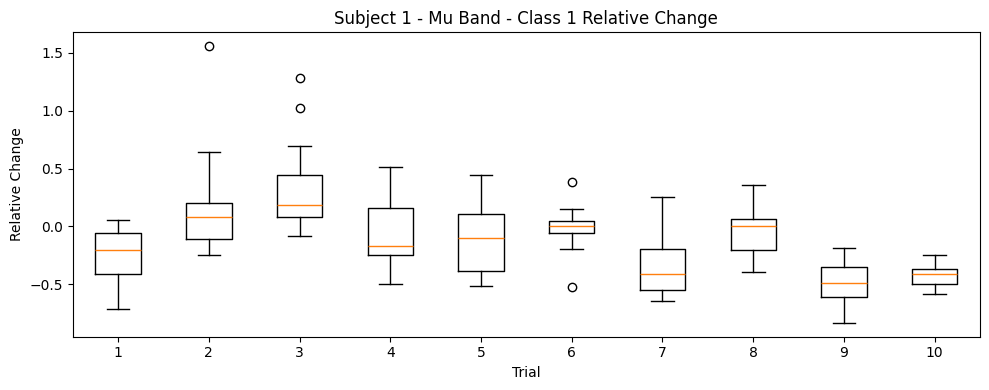

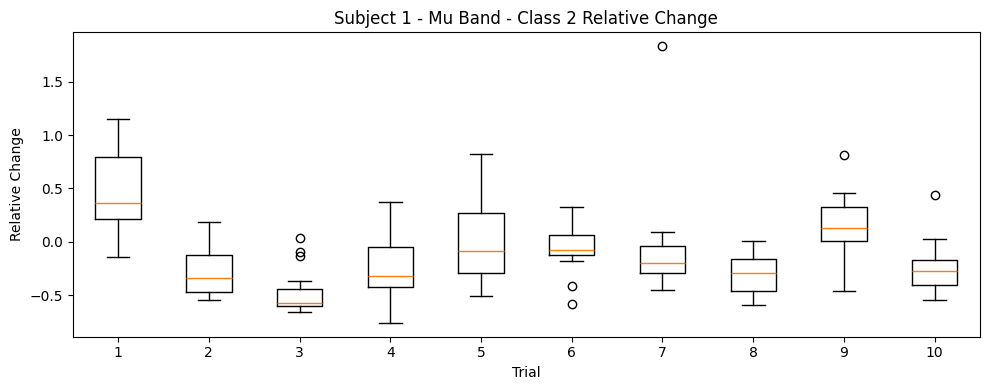

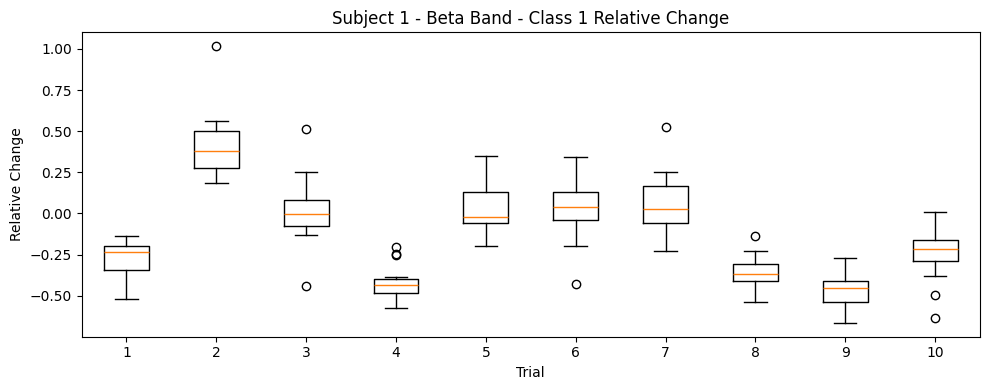

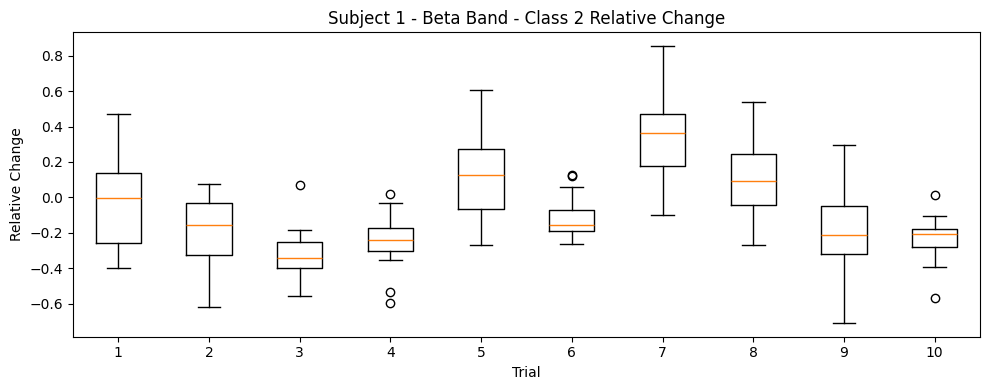

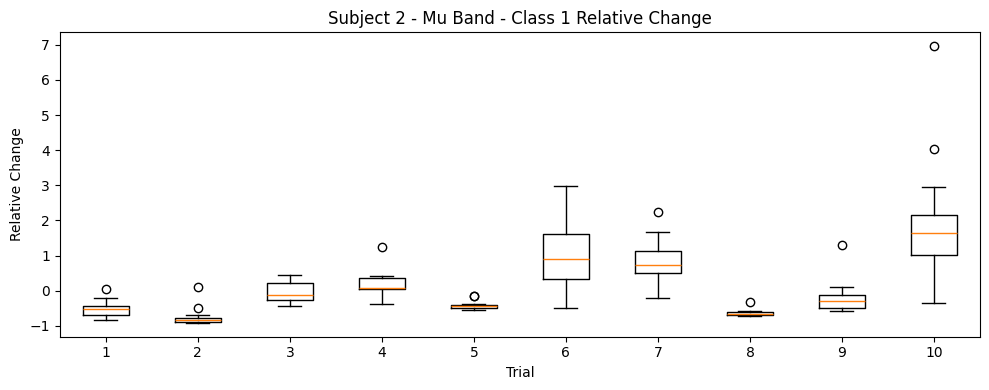

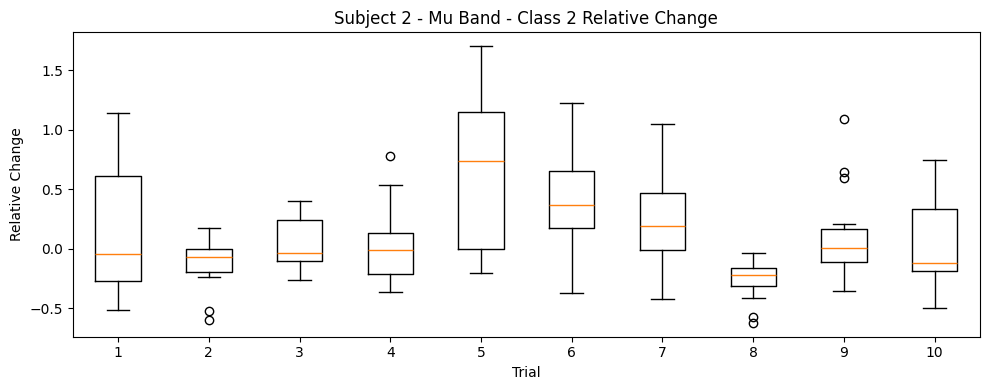

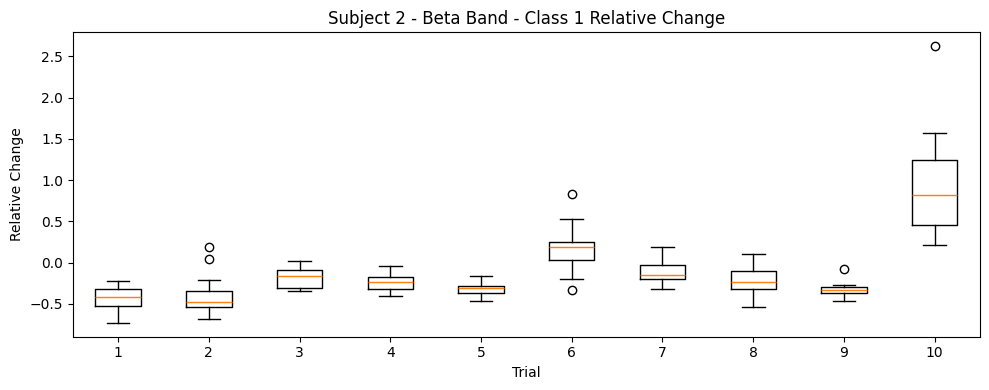

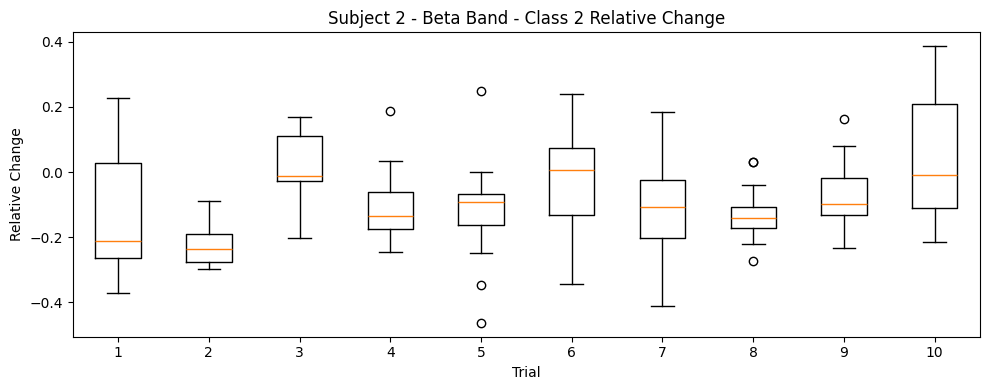

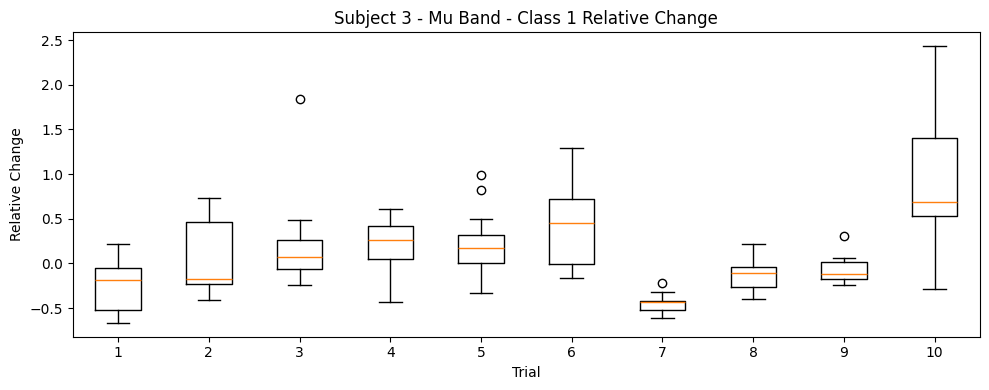

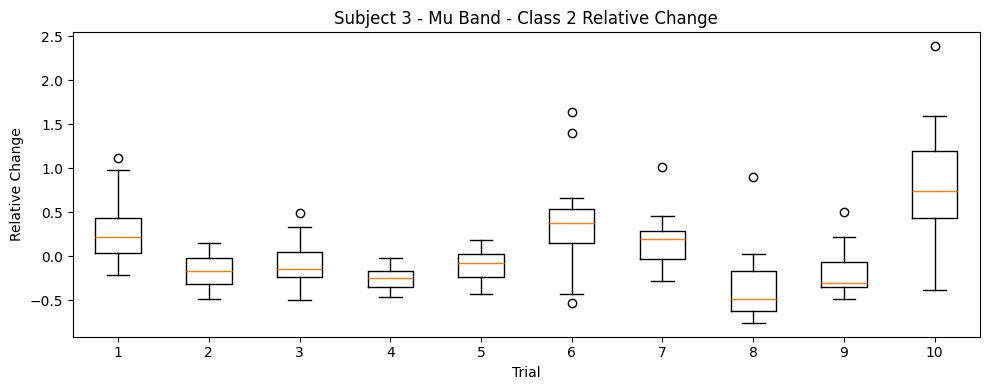

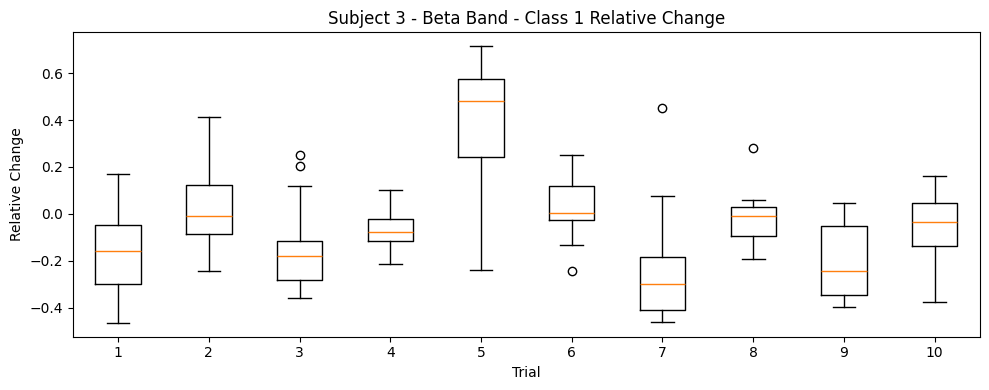

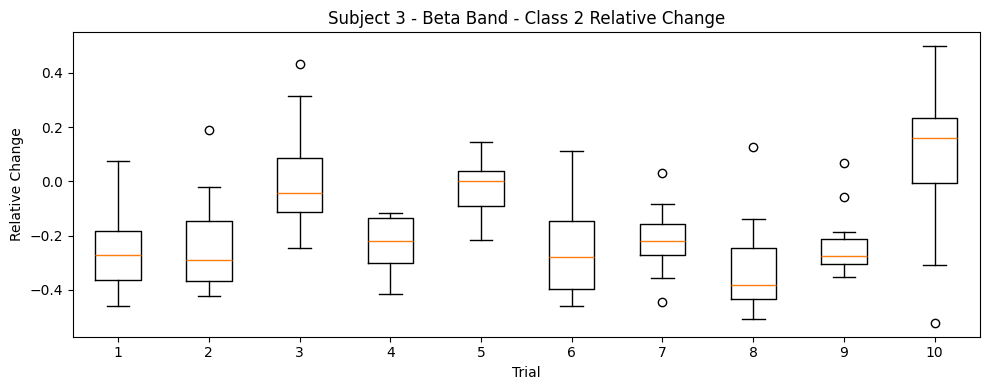

In [40]:
"""
To capture the distribution(median and outliers) of the relative change in power for each trial for each subject for each band,
we make use of boxplots.
"""

for subject in range(num_subjects):
    for band in ['Mu', 'Beta']:
        for trial_class in [1, 2]:
            relative_change = subjects_relative_change[f"{band.lower()}_band_class{trial_class}"][subject]
            
            plt.figure(figsize=(10, 4), tight_layout=True)
            plt.boxplot(relative_change)
            plt.title(f"Subject {subject + 1} - {band} Band - Class {trial_class} Relative Change")
            plt.xlabel('Trial')
            plt.ylabel('Relative Change')
            plt.show()

# Line Plot across trials

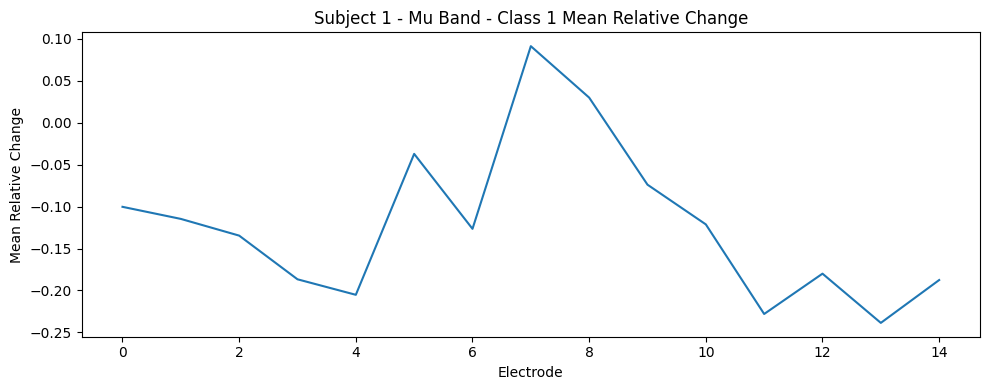

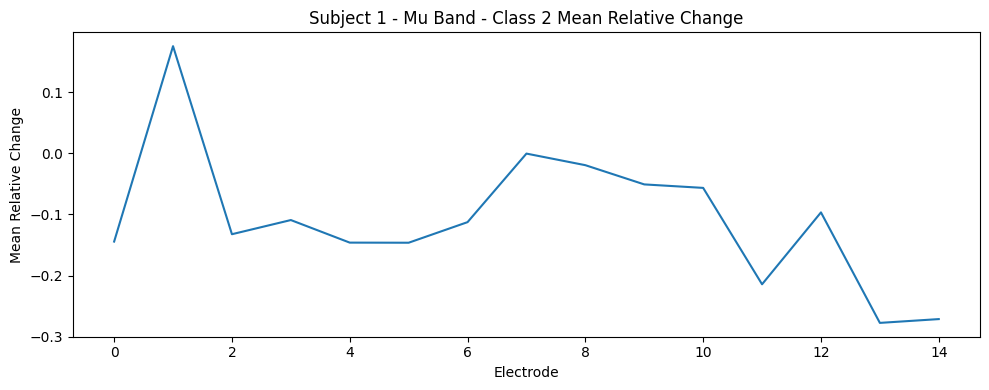

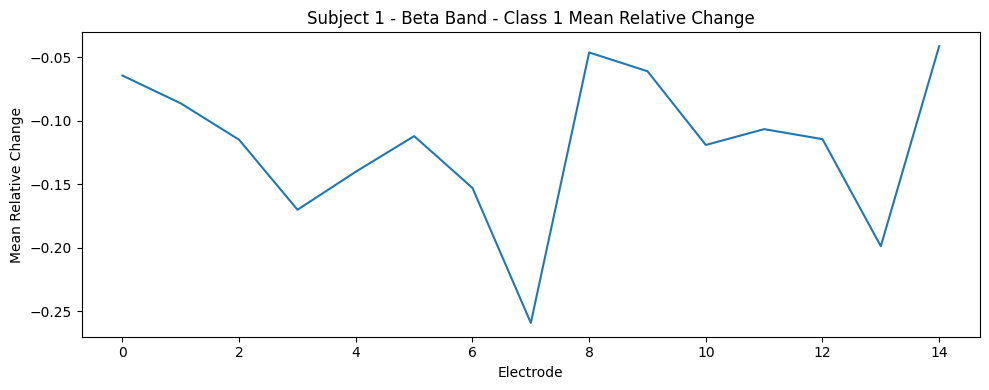

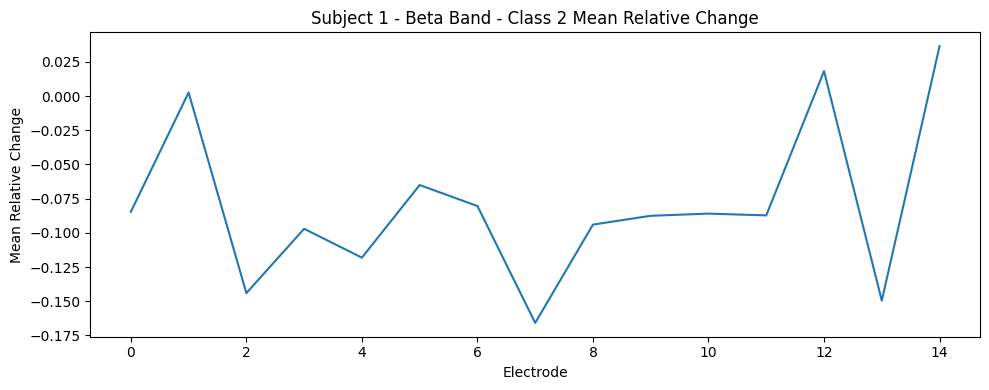

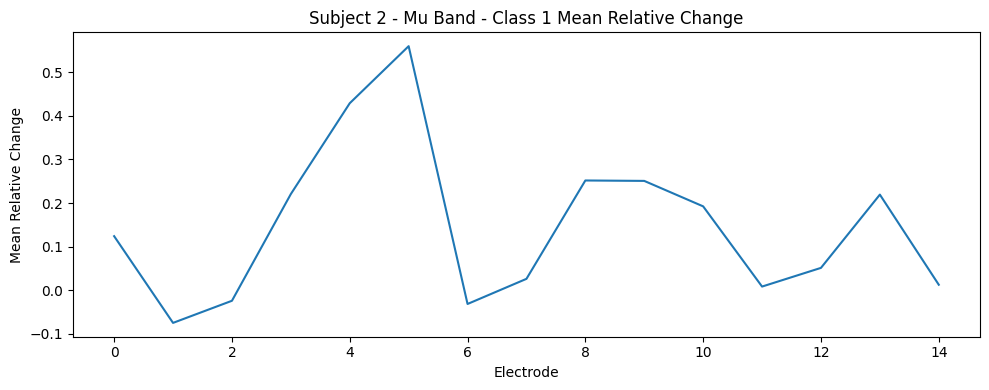

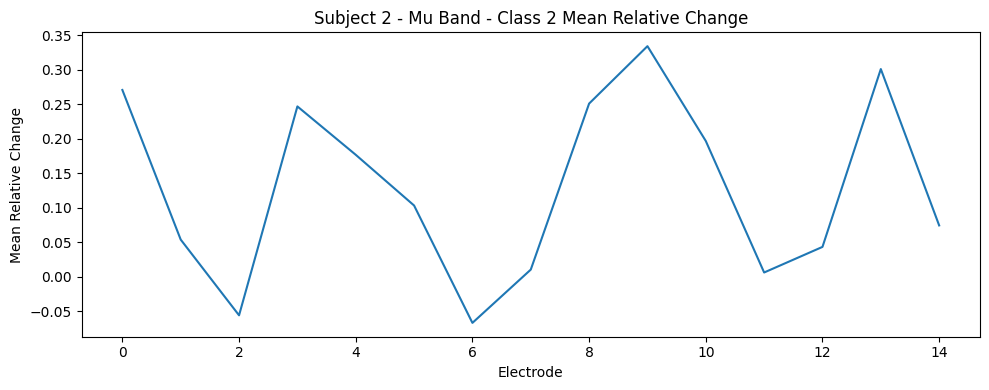

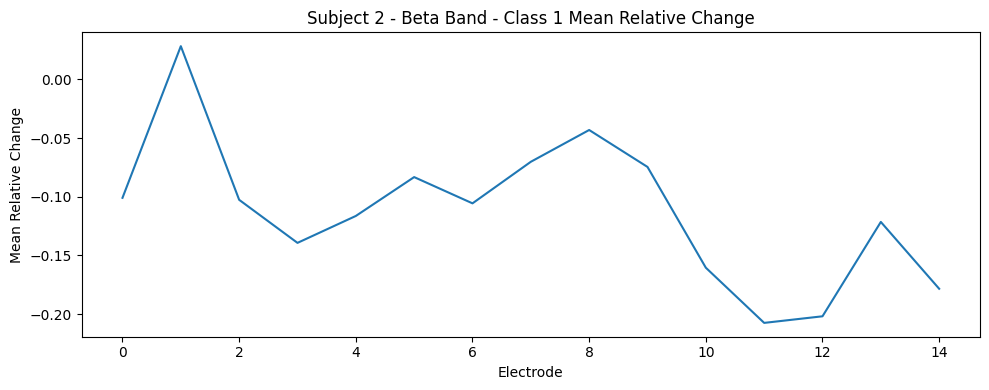

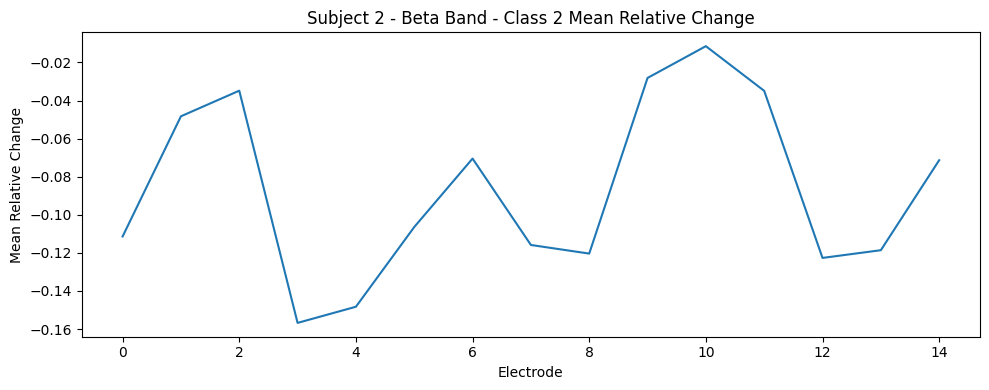

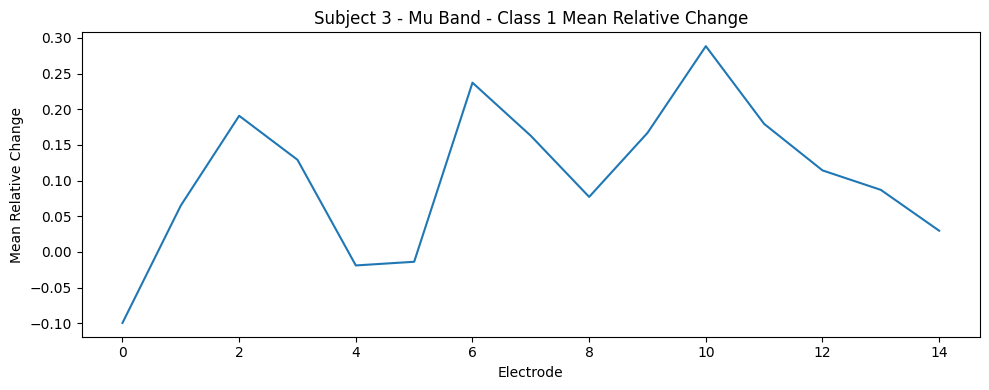

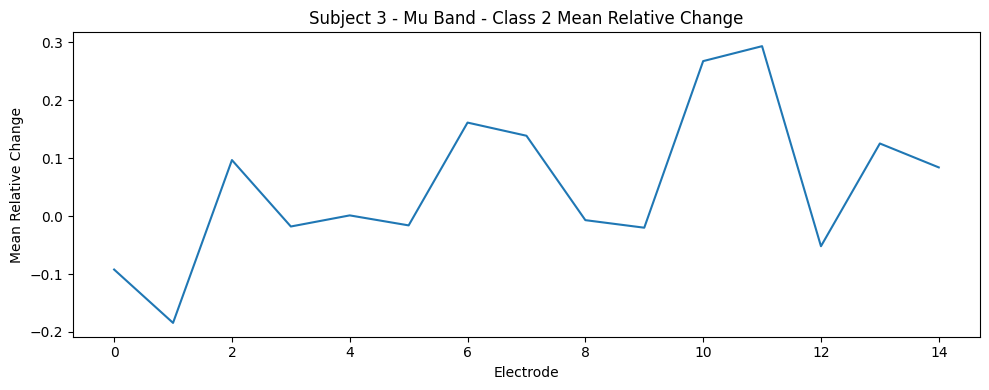

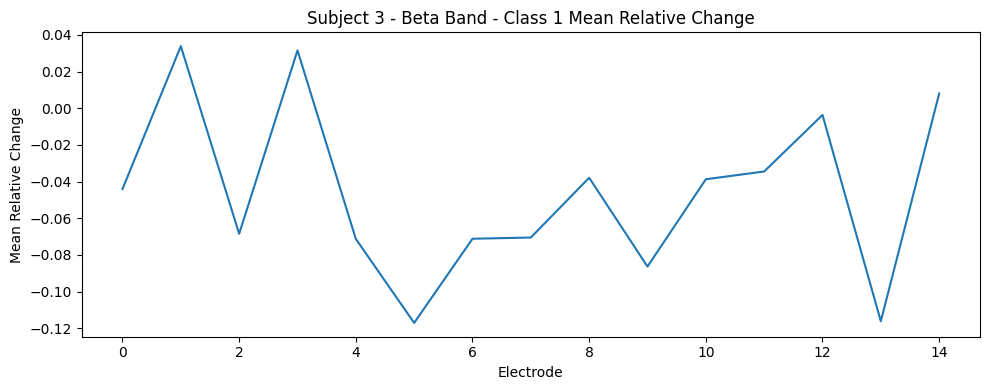

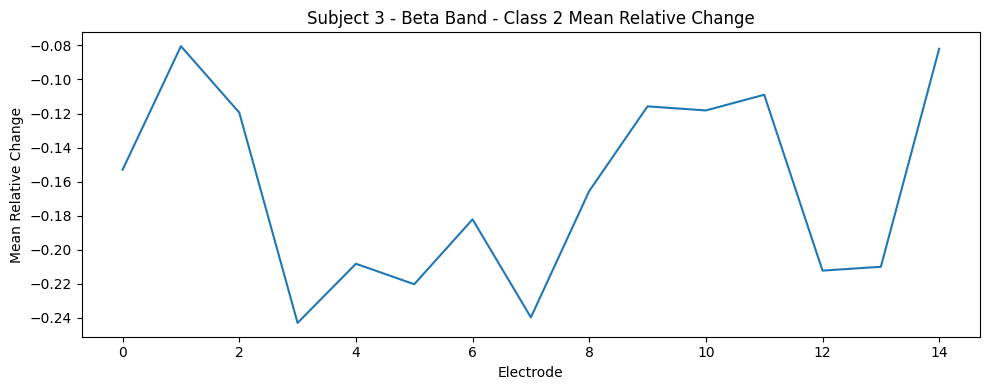

In [42]:
"""
Relative change in power for each electrode, aggregated across all trials for each subject for each band.
"""

for subject in range(num_subjects):
    for band in ['Mu', 'Beta']:
        for trial_class in [1, 2]:
            relative_change = subjects_relative_change[f"{band.lower()}_band_class{trial_class}"][subject]
            mean_relative_change = np.mean(relative_change, axis=0)
            
            plt.figure(figsize=(10, 4), tight_layout=True)
            plt.plot(mean_relative_change)
            plt.title(f"Subject {subject + 1} - {band} Band - Class {trial_class} Mean Relative Change")
            plt.xlabel('Electrode')
            plt.ylabel('Mean Relative Change')
            plt.show()


# Line Plot across bands, subjects

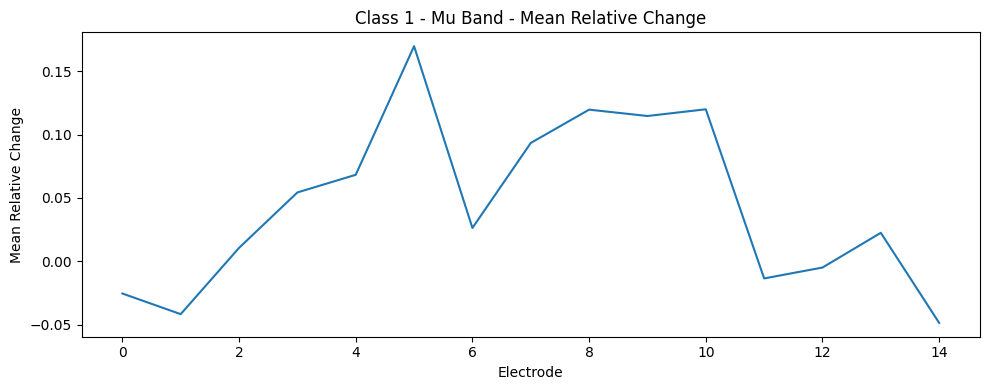

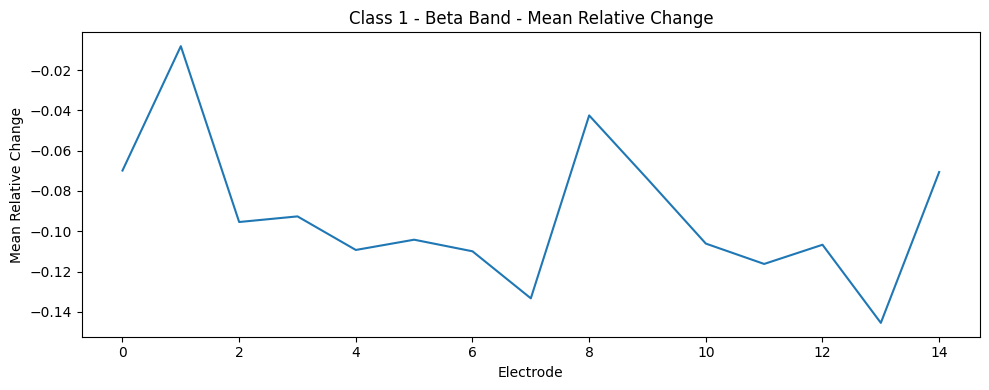

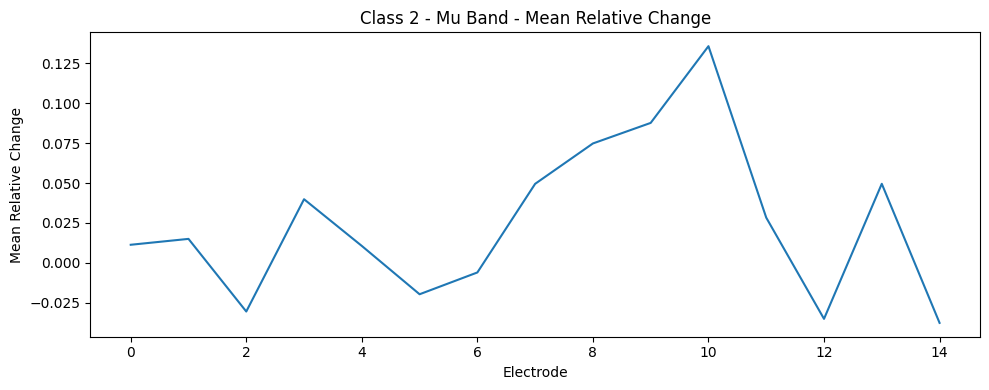

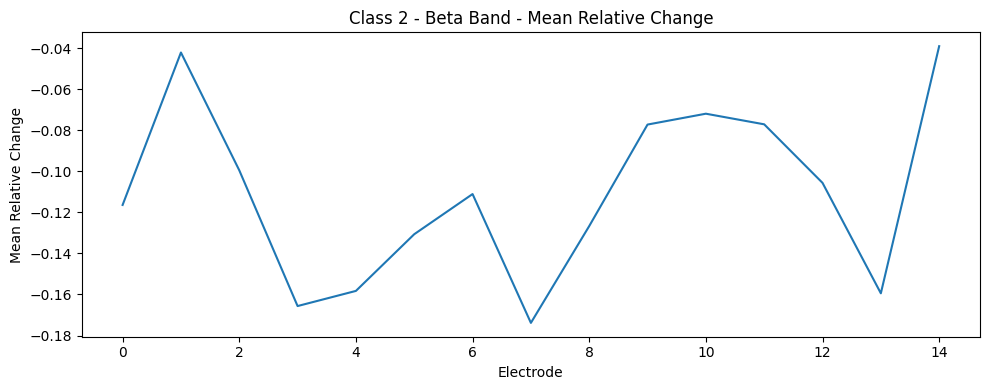

In [43]:
"""
Relative change in power for each electrode, aggregated across all subjects for each band.
"""

for trial_class in [1, 2]:
    for band in ['Mu', 'Beta']:
        mean_relative_change = np.mean(subjects_relative_change[f"{band.lower()}_band_class{trial_class}"], axis=0)
        mean_relative_change = np.mean(mean_relative_change, axis=0)  # mean across all subjects
        
        plt.figure(figsize=(10, 4), tight_layout=True)
        plt.plot(mean_relative_change)
        plt.title(f"Class {trial_class} - {band} Band - Mean Relative Change")
        plt.xlabel('Electrode')
        plt.ylabel('Mean Relative Change')
        plt.show()
